How I plan to start this off. (Jean)

In [1]:
# Just took whatever libraries he put on from class notes so I don't go back and forth. Will change later (maybe?)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

In [2]:
#Load Data
train_df = pd.read_csv("train.csv.zip")
train_df.head()
train_df.shape

(159571, 8)

In [3]:
# Vectorizing Data and Processessing
text = train_df['comment_text'].head(n=2000)
y = train_df['insult'].head(n=2000)

tf_idf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
tmp_vec = tf_idf.fit_transform(text)

#TF-IDF
vec_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), stop_words="english", strip_accents="unicode")
tmp = vec_tf.fit_transform(text)
tok_cols = vec_tf.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", text.shape)
print("vectorized:", tmp.shape)
tok_df.sample(5)

original: (2000,)
vectorized: (2000, 182311)


,00,00 02,00 02 august,00 02 august 11,00 2007,00 44,00 bst,00 bst understand,00 bst understand evening,000,...,翻译,翻译 თარგმანი,翻译 თარგმანი μεταφραση,翻译 თარგმანი μεταφραση અન,見学,見学 迷惑,迷惑,連絡,連絡 見学,連絡 見学 迷惑
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


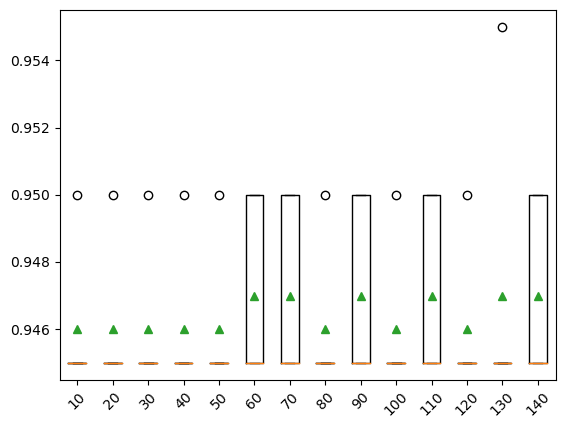

In [4]:
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,15):
		n = i*10
		steps = [('svd', TruncatedSVD(n_components=n)), ('m', LinearSVC(max_iter=100, tol=.01))]
		models[str(n)] = Pipeline(steps=steps)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	#Splits cut for speed
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, tok_df[0:1000], y[0:1000])
	results.append(scores)
	names.append(name)
# plot model performance for comparison

plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [12]:
text = train_df['comment_text'].head(n=2000)
y = train_df['insult'].head(n=2000)

tf_idf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
tmp_vec = tf_idf.fit_transform(text)

tok_cols2 = tf_idf.get_feature_names_out()
tmp_df = pd.DataFrame(tmp_vec.toarray(), columns=tok_cols2)

In [13]:
tmp_df.shape

(2000, 125773)

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(tmp_df, y)

In [15]:
# Our Baselien accuarcy
text = train_df['comment_text'].head(n=2000)
y = train_df['insult'].head(n=2000)

tf_idf_base = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode", max_features=2000)
tmp_vec_base = tf_idf_base.fit_transform(text)

tok_cols2_base = tf_idf_base.get_feature_names_out()
tmp_df_base = pd.DataFrame(tmp_vec_base.toarray(), columns=tok_cols2_base)
X_tr_base, X_te_base, y_tr_base, y_te_base = train_test_split(tmp_df_base, y)

pipe_steps = [("scale", StandardScaler()), ("model", SVC())]
pipe_test = Pipeline(steps=pipe_steps)

pipe_test.fit(X_tr_base, y_tr_base)
pipe_test.score(X_te_base, y_te_base)

0.96

Baseline Accuarcy: 0.952

In [16]:
svd_tmp = TruncatedSVD(n_components=10)
pipe_steps = [("scale", StandardScaler()), ("svd", svd_tmp), ("model", SVC())]
pipe_test = Pipeline(steps=pipe_steps)

pipe_test.fit(X_tr, y_tr)
pipe_test.score(X_te, y_te)

0.946

In [17]:
for index, component in enumerate(svd_tmp.components_):
    zipped = zip(tok_cols2, component)
    top_terms_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:6]
    top_terms_list = list(dict(top_terms_key).keys())
    print("Topic:"+str(index)+" ", top_terms_list)

Topic:0  ['125', '1930', 'cambridge', 'cambridge university', 'central european', 'dem']
Topic:1  ['christianity', 'southgate', 'myths', 'renaissance', 'reviews', '100 southgate']
Topic:2  ['kacic', 'dinaric', 'dalmatian', 'famous', '1547', '1547 contemporary']
Topic:3  ['14 november', 'did feel', 'discussion right', 'en wiki', 'experiences', 'formatting style']
Topic:4  ['gamecube', 'spaces', 'mode', 'minigame', 'minigames', 'pot']
Topic:5  ['anarcho', 'moral philosophy', 'philosophical conversation', 'philosophical questions', 'philosophy particularly', 'stefan']
Topic:6  ['article clearly', 'cycle', 'escalating', 'opportunity suggest', 'trading', 'alexander great']
Topic:7  ['reserved', 'reserved image', 'rights reserved', 'rights reserved image', 'non commercial', 'creative commons']
Topic:8  ['edits just', 'need make', 'procedures', 'soapbox', 'symbols', 'use real']
Topic:9  ['randroide', 'agree course', 'article sources', 'does make sense', 'enable', 'jokes']


In [18]:
from gensim.models import Word2Vec
nltk.download('all')
import nltk
for package in ['stopwords','punkt','wordnet']:
    nltk.download(package) 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Jean\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Jean\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Jean\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Jean\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Jean\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

In [7]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

In [8]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

In [9]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.lemmatizer.lemmatize(tok))
        return filtered_tok

In [10]:
from sklearn.svm import SVC
vec_tf = TfidfVectorizer()
model_svc = SVC()

y = train_df["insult"].head(n=7000)
X = train_df["comment_text"].head(n=7000)

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe2 = Pipeline([ 
                    #("vect", vec_cv),
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = {"vect__max_features":[100,500,1000,1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }

grid = GridSearchCV(estimator  = pipe2, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy")

grid.fit(X_train, y_train.ravel())
best = grid.best_estimator_
preds = best.predict(X_test)
print(best)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Jean\anaconda3\Lib\site-packages\sklearn\

KeyboardInterrupt: 